# Coastline compare.
### This notebook tries to use sentinel one data to extract a time series of coastlines for a given aoi


In [10]:
# imports needed for the rest of the notebook.

import numpy as np
import pandas as pd
import collections
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray
import scipy
import datacube
from shapely.geometry import MultiLineString, mapping
from skimage.measure import find_contours
from datacube.storage import masking
from matplotlib import cm
import utils
#from utils.display import display_map

In [17]:
# Define area of interest
# Fiji
x = (177.481, 177.855)
y = (-18.00, -18.3732)
time = ("2018-04-01", "2019-04-01")

# How often to extract coast line polygons.
time_step = '2M'

In [18]:
#display_map(latitude=y, longitude=x)

In [19]:
# percentage of total of images in a time window that need to be water to include in the output.
threshold = 75 
min_vertices = 100
# water settings in sar
vv_threshold = 12
vh_threshold = -15.5

# tuneable parameters 
output_shp = f's1_land_water-{threshold}.shp' # output filename

In [22]:
# Do the query to get the data. This may take a while, depending on your aoi settings.
# query parameters
res = (-30,30)
crs = "EPSG:4326"

query=({'x':x,
        'y':y,
        'crs':crs,
        'resolution':res,
        'time': time})

dc = datacube.Datacube(app="s1_coastline")

# load up the data and filter down to water
#s1_coverage = dc.load(product="s1_gamma0_scene", output_crs ="EPSG:32760", **query)
s1_coverage = dc.load(product="s1g_gamma0_scene", output_crs ="EPSG:32760", **query)
s1_coverage = masking.mask_invalid_data(s1_coverage)
s1_coverage['water'] = ((s1_coverage["vv"] <= vv_threshold) & (s1_coverage["vh"] <= vh_threshold))

In [23]:
# define save polygon function
def save_poly(output_geojson, crs, polygon):
    
    attribute_data = {} 
    attribute_dtypes = {} 
    schema = {'geometry': 'MultiLineString',
          'properties': attribute_dtypes}
    
    with fiona.open(output_geojson, 'w',
                crs={'init': str(crs), 'no_defs': True},
                driver='GeoJSON',
                schema=schema) as output:

        # Create multi-string object from all contour coordinates
        contour_multilinestring = MultiLineString(polygon)

        # Get attribute values for writing
        attribute_vals = {field_name: field_vals[i] for field_name, field_vals in 
                          attribute_data.items()}

        # Write output shapefile to file with z-value field
        output.write({'properties': attribute_vals,
                      'geometry': mapping(contour_multilinestring)})

In [24]:
def extract_contour(data_source, data, threshold, min_vertices):
    ds_affine = data_source.geobox.transform
    ps = ds_affine[0]  # Compute pixel size

    contours_geo = [np.column_stack(ds_affine * (i[:, 1], i[:, 0])) + np.array([0.5 * ps, -0.5 * ps]) for i in
                    find_contours(data, threshold)]
    contours_nona = [i[~np.isnan(i).any(axis=1)] for i in contours_geo]
    contours_withdata = [i for i in contours_nona if len(i) >= min_vertices]
    return contours_withdata

In [25]:
chunks = s1_coverage['water'].resample(time=time_step).sum('time')
for t in range(0, chunks.time.size):
    layer = chunks.isel(time=t)
    layer_max = layer.max().values
    layer_threshold = (layer_max / 100 ) * threshold
    print(f"{t} t: {layer_threshold} m: {layer_max}")
    print(layer.time.values)
    #layer.where(layer > layer_threshold).plot.imshow(figsize=(12,10))
    contour = extract_contour(s1_coverage, layer, layer_threshold, min_vertices)
    save_poly(f"coast2_{layer.time.values}.geojson", s1_coverage.crs, contour)

0 t: 3.75 m: 5
2018-04-30T00:00:00.000000000
1 t: 7.5 m: 10
2018-06-30T00:00:00.000000000
2 t: 6.75 m: 9
2018-08-31T00:00:00.000000000
3 t: 7.5 m: 10
2018-10-31T00:00:00.000000000
4 t: 7.5 m: 10
2018-12-31T00:00:00.000000000
5 t: 6.75 m: 9
2019-02-28T00:00:00.000000000
6 t: 3.75 m: 5
2019-04-30T00:00:00.000000000


In [37]:
# load in the tide data. Edit this to make sure you have data that overlaps with what you are working on.
# the data here comes from http://www.bom.gov.au/oceanography/projects/spslcmp/data/index.shtml for fiji
tide_files = ['tides/IDO70004_2017.csv', 'tides/IDO70004_2018.csv', 'tides/IDO70004_2019.csv']
year_files = []
for f in tide_files:
    tide_data = pd.read_csv(f, parse_dates=['time'], index_col='time')
    year_files.append(tide_data)
    
tide_data = pd.concat(year_files)

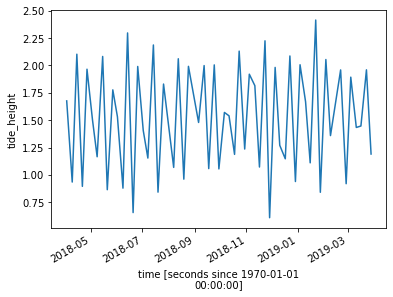

In [38]:


tide_data_xr = tide_data.to_xarray()

# We want to convert our hourly tide heights to estimates of exactly how high the tide was at the time that
# each satellite image was taken. To do this, we can use `.interp` to 'interpolate' a tide height for each
# s1 timestamp:
s1_tideheights = tide_data_xr.interp(time=s1_coverage.time)

# We then want to put these values back into the s1 dataset so that each image has an estimated tide height:
s1_coverage['tide_height'] = s1_tideheights.tide

# Plot the resulting tide heights for each Landsat image:
s1_coverage.tide_height.plot()
plt.show()